# PyTorch Paper Replicating

The goal of machine learning research paper replicating is : turn a ML research paper into usable code.

In this notebook, we will be implementing ViT (Vision Transformer)

## 0. Get Setup

Let's import code we've previously written + required libraries.

In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves


[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 11.91 MiB/s, done.
Resolving deltas: 100% (2657/2657), done.
Updating files: 100% (248/248), done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get Data

The whole goal of what we're trying to do is to replicate the ViT architecture for our FoodVision Mini problem.

to do that , we need some data , namely pizza, steak, sushi data

In [3]:
image_path = download_data(source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip",
                          destination = "pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [4]:
train_dir = image_path/"train"
test_dir = image_path /"test"


In [5]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

In [6]:
from going_modular.going_modular import data_setup
from torchvision import transforms
#Create image size
IMG_SIZE = 224 # comes from Table 3 of ViT paper

#Create transforms pipeline
manual_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor()
    ]
)
print(f"Manually created transforms : {manual_transforms}")
# #Create transforms pipeline
# data_setup.create_dataloaders(
    
# )

Manually created transforms : Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
#Create a batch size of 32 (Paper uses 4096)
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir =test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE
)

In [8]:
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

As always, let's adhere to the motto, visualize, visualize...

In [9]:
image_batch , label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

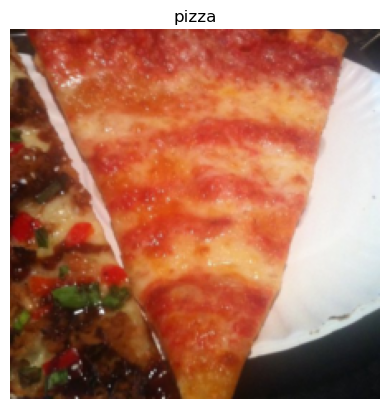

In [10]:
import matplotlib.pyplot as plt

plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

## 3. replicating ViT Overview

Looking at a whole machine learning research paper can be intimidating.
So in order to make it more understandable , we can break it down into smaller pieces:

* **Inputs** - What goes into model (in our case, image tensors)
* **Outputs** - What comes out of model/layer/block
* **Layers** - Takes an input, manipulates it with a fucntion
* **Blocks** - Stack of layers
* **Model** - collection of blocks

### 3.1 ViT overview : pieces of puzzle

* Figure 1 : Visual overview of architecture
* Four equations : math equations which define functions of each layer/block
* Table 1/3 : different hyperparameters for architecture/training.

### Figure 1

<img src = "https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-figure-1-architecture-overview.png?raw=true"
     wdith=600 alt="figure 1 from vision transformer paper"/>

### Four equations

<img src="https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-four-equations.png?raw=true" width=600 alt="four equations from vision transformer paper"/>

##### Section 3.1 describes various equations:

**Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where ( $H, W$ ) is the resolution of the original image, $C$ is the number of channels, ( $P, P$ ) is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

In pseudocode:
```python

x_input = [class_name, image_patch_1, image_patch_2, ....,image_patch_N] + [class_token_pos , image_patch_1_pos, image_patch_2_pos, ...]
```

**Equation 2&3:**
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

In pseudocode:
```python
#Equation 2
x_output_MSA_block = MSA_layer(LN_layer(x_input))+ x_input

#Equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block))+ x_output_MSA_block
```

**Equation 4:**
Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches ( $\mathbf{z}_0^0=\mathbf{x}_{\text {class }}$ ), whose state at the output of the Transformer encoder ( $\mathbf{z}_L^0$ ) serves as the image representation $\mathbf{y}$ (Eq. (4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

* MLP 

### Table 1

<img src="https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-table-1.png?raw=true" width=600 alt="table 1 from vision transformer paper" />

* ViT-Base , ViT-Large , ViT-Huge are all different sizes of same model architecture.
* Layers - the number of transformer encoder layers (no. of transformer encoder blocks)
* Hidden size $D$ - the embedding size throughout architecture
* MLP size - the number of hidden units/neurons in MLP
* Head - the number of multi-self attention

### 4 . Equation 1 : Split data into patches and creating the class, position and patch embedding

Layers = input-> function -> output

What's the input shape?

What's the output shape?

* Input Shape : (224,224,3) -> single image -> (height, width, color channels)
* Output shape : 

#### 4.1 calculating input, output shapes

In [11]:
#Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

#Calculate number of batches
number_of_patches = int((height*width) / patch_size**2)
number_of_patches

196

In [12]:
#Input shape
embedding_layer_input_shape = (height, width, color_channels)

#Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches) : {embedding_layer_output_shape} -> (number_of_patches, embedding_dimension)")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches) : (196, 768) -> (number_of_patches, embedding_dimension)


#### 4.2 Turning a single image into patches

Let's visualize

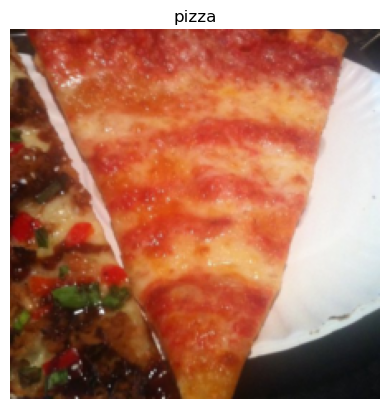

In [13]:
#view a single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [14]:
image.shape

torch.Size([3, 224, 224])

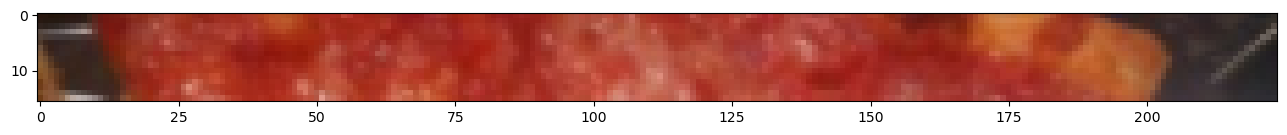

In [15]:
#get top row of image
image_permuted = image.permute(1,2,0) # Convert image to color channels last (H,W,C)

patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size , : , :])

Number of patches per row : 14.0
Patch size : 16 pixels x 16 pixels


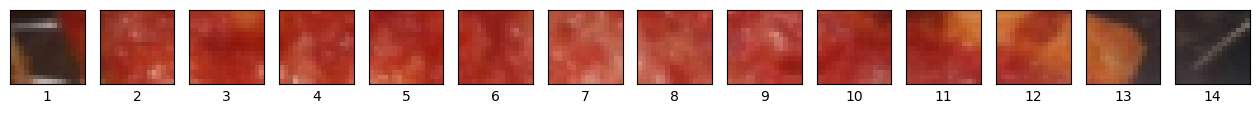

In [16]:
#Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size%patch_size == 0, "Image size must be divisible by patch size"

print(f"Number of patches per row : {num_patches}\nPatch size : {patch_size} pixels x {patch_size} pixels")

#Create a series of subplots
fig, axs = plt.subplots(
    nrows = 1,
    ncols = img_size // patch_size, # one column for each patch
    sharex = True,
    sharey = True,
    figsize = (patch_size, patch_size)
)

#Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted [:patch_size, patch: patch+patch_size , :]);
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

In [17]:
num_patches

14.0

Number of patches per row : 14.0
Number of patches per column : 14.0
Total patches : 196.0
Patch size : 16 pixels x 16 pixels


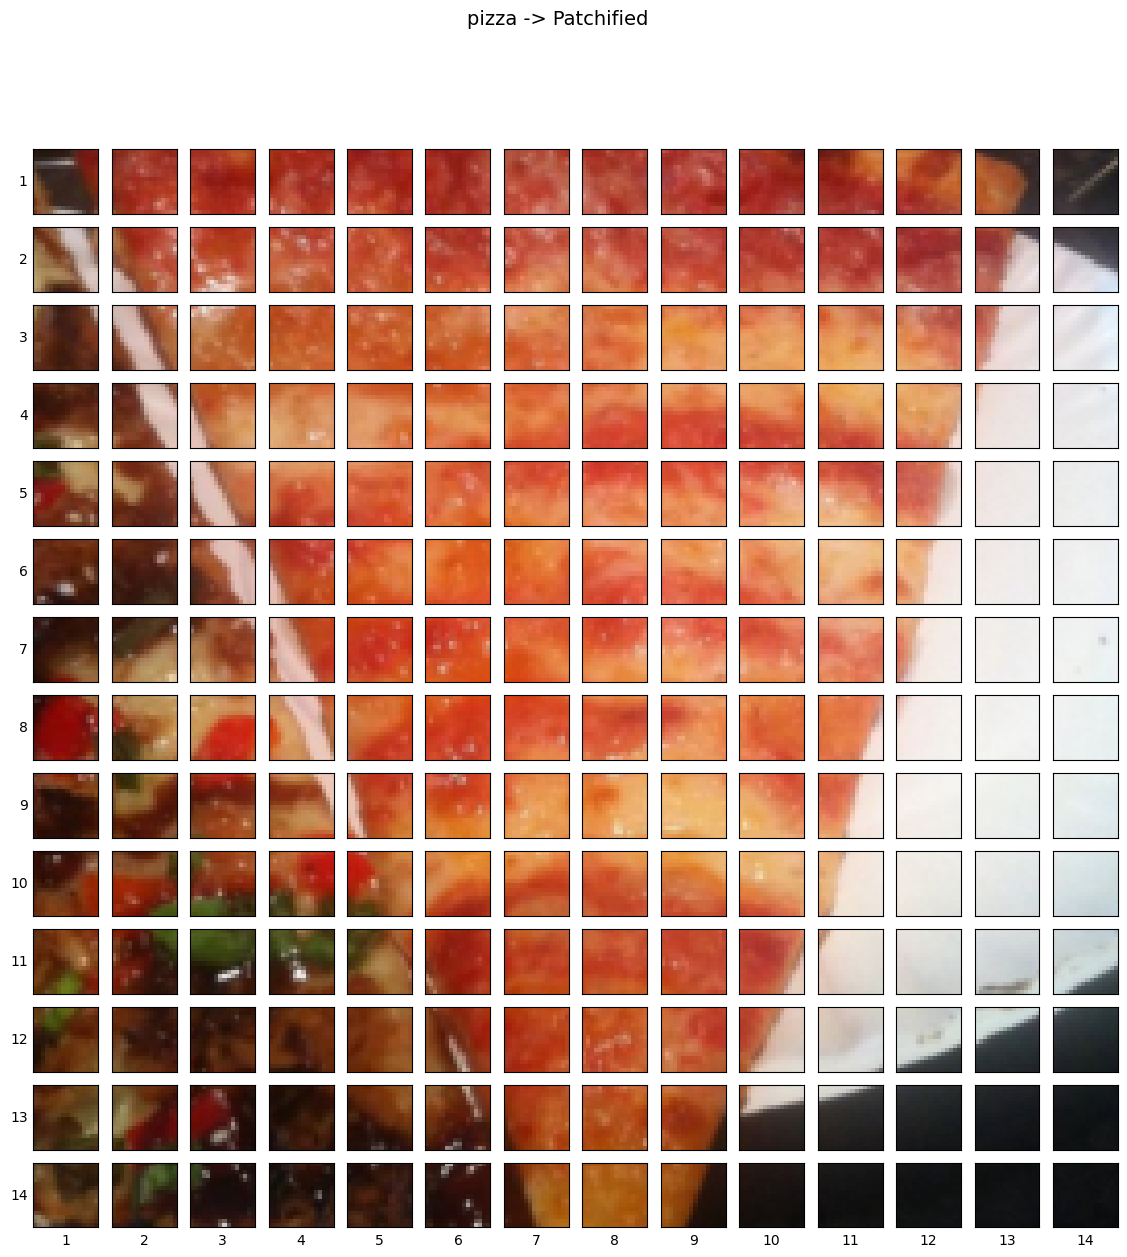

In [18]:
#Setup code to plot whole images as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0 , "Image size must be divisible by patch_size"
print(f"Number of patches per row : {num_patches}\
\nNumber of patches per column : {num_patches}\
\nTotal patches : {num_patches*num_patches}\
\nPatch size : {patch_size} pixels x {patch_size} pixels"
     )

#Create a series of subplots 
fig, axs = plt.subplots(nrows = img_size // patch_size,
                        ncols = img_size // patch_size,
                        figsize = (num_patches, num_patches),
                        sharex = True,
                        sharey = True)

#Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size , patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axs[i,j].imshow(image_permuted[patch_height: patch_height+patch_size,
                        patch_width: patch_width+patch_size,
                        :])
        axs[i,j].set_ylabel(i+1, rotation="horizontal", horizontalalignment="right",verticalalignment="center")
        axs[i,j].set_xlabel(j+1)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].label_outer()

#Setup a title for plot
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)
plt.show()
    

#### 4.3 Creating image patches and turning them into patch embeddings

Perhaps we could create the image patches and image patch embeddings in a single step using torch.nn.Conv2d 

In [19]:
#Create conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn

patch_size = 16

#Create conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels = 3,
                   out_channels= 768,
                   kernel_size = patch_size,
                   stride = patch_size,
                   padding =0
                  )
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [20]:
image.shape

torch.Size([3, 224, 224])

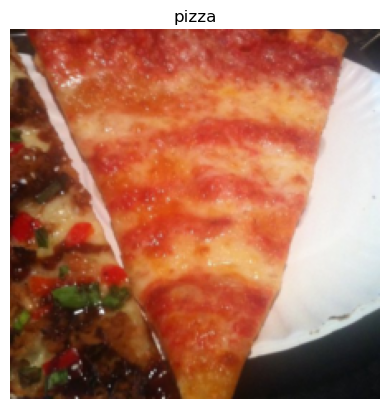

In [21]:
#View single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [22]:
#Pass image through convolutiuonal layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension -> batch_size, color_channels, height, width
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes : [281, 418, 243, 470, 353]


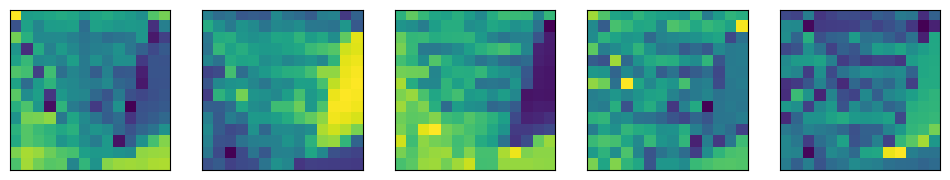

In [23]:
#plot random convolutional feature maps (embeddings)
import random
random_indexes = random.sample(range(0,758), k=5)
print(f"Showing random convolutional feature maps from indexes : {random_indexes}")

#Create plot
fig, axs = plt.subplots(nrows = 1, ncols = 5, figsize=(12,12))

for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[: , idx , :, :] 
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) #remove batch dimension and switch to numpy for matplotlib
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [24]:
single_feature_map = image_out_of_conv[:,0,:,:]
single_feature_map, single_feature_map.requires_grad

(tensor([[[0.1766, 0.2585, 0.2738, 0.2814, 0.2578, 0.2630, 0.3965, 0.3504,
           0.3118, 0.2753, 0.2683, 0.3525, 0.2661, 0.1681],
          [0.4457, 0.4221, 0.5243, 0.3737, 0.4085, 0.3784, 0.4999, 0.4582,
           0.3767, 0.3673, 0.3939, 0.3544, 0.6496, 0.5784],
          [0.2091, 0.5607, 0.4581, 0.3982, 0.3742, 0.4004, 0.4871, 0.5010,
           0.6199, 0.6069, 0.6016, 0.5470, 0.7744, 0.9356],
          [0.2736, 0.4199, 0.5123, 0.5808, 0.5417, 0.5208, 0.4381, 0.4157,
           0.4551, 0.4704, 0.5374, 0.6699, 0.9032, 0.9510],
          [0.2189, 0.2743, 0.6359, 0.4141, 0.4266, 0.4815, 0.5005, 0.5578,
           0.5191, 0.5757, 0.5633, 0.6822, 0.9375, 0.9581],
          [0.1917, 0.1609, 0.4312, 0.3508, 0.4315, 0.4149, 0.4387, 0.5023,
           0.5468, 0.5737, 0.6652, 0.8702, 0.9482, 0.9662],
          [0.1598, 0.3927, 0.4101, 0.5530, 0.3757, 0.3998, 0.4358, 0.5425,
           0.5881, 0.5367, 0.5731, 0.8730, 0.9629, 0.9639],
          [0.1812, 0.4608, 0.3556, 0.6358, 0.3520, 0.34

#### 4.4 Flattening the patch embedding with 'torch.nn.Flatten()'

Right now we've a series of convolutional feature maps (patch_embeddings) that we want to flatten into a sequence of patch embeddings to satisfy criteria of ViT Transformer Encoder.

In [25]:
print(f"{image_out_of_conv.shape} -> (batch_size, embedding_dim, feature_map_height, feature_map_width)")

torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_map_height, feature_map_width)


Want : (batch_size, number_of_patches, embedding_dim)

In [26]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape : torch.Size([3, 224, 224])
Image feature map (patches) shape : torch.Size([1, 768, 14, 14])
Flattened image feature map shape : torch.Size([1, 768, 196])


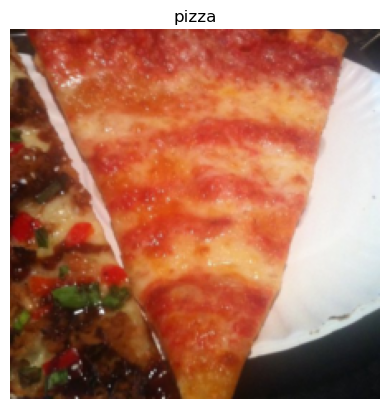

In [27]:
#Put everything together
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape : {image.shape}")

#Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0))
print(f"Image feature map (patches) shape : {image_out_of_conv.shape}")

#Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape : {image_out_of_conv_flattened.shape}")

In [28]:
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0,2,1)
print(f"{image_out_of_conv_flattened.permute(0,2,1).shape} -> (batch_size, number_of_patches, embedding_dimension)")

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dimension)


Text(0.5, 1.0, 'Flattened feature map shape : torch.Size([1, 196])')

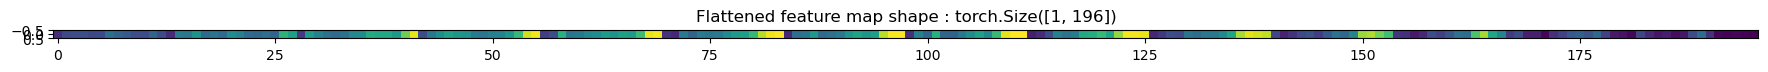

In [29]:
#Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]
single_flattened_feature_map

#Plot flattened feature map visually
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape : {single_flattened_feature_map.shape}")

#### 4.5 Turning the ViT patch embedding layer into Pytorch module

We want this module to do few things:
1. Create a class called 'PatchEmbedding' that inherits from `nn.Module`
2. Initialize with appropriate hyperparameters , such as channels, embedding dimension, patch size.
3. Create a layer to turn an image into embedding patches using `nn.Conv2d()`
4. Create a layer to flatten the feature maps of the output of layer in 3.
5. Define a `forward()` that defines the forward computation (e.g pass through layer 3, 4)
6. Make sure output shape of layer reflects required output shape of patch embeddings

In [30]:
#1. create class called PatchEmbedding
class PatchEmbedding(nn.Module):
    #2. Initialize layer with appropriate hyperparameters
    def __init__(self,
                 in_channels = 3,
                 patch_size = 16,
                 embedding_dim:int=768): # from table 1 for ViT-Base
        super().__init__()
        self.patch_size = patch_size
        #3. Create a layer to turn image into embedded patches
        self.patcher = nn.Conv2d(in_channels = in_channels, out_channels=embedding_dim, kernel_size = patch_size, stride = patch_size,
                                 padding = 0)

        #4. Flatten feature map outputs of conv2s
        self.flatten = nn.Flatten(
            start_dim =2,
            end_dim = 3
        )

    #5 , Define forward method to define forward computation steps
    def forward(self, x):
        #Create assertion to check that inputs are correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0 , f"Input image size must be divisible by patch size, image shape : {image_resolution},patch_size : {self.patch_size}"

        #Perform forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        #6. Make sure returned sequence embeddings are in right order (batch_size, number_of_patches, embedding_dimension)
        return x_flattened.permute(0,2,1)
        
        

In [31]:
set_seeds()

#Create instance of patch embedding layer
patchify = PatchEmbedding(in_channels = 3,
                          patch_size = 16,
                          embedding_dim = 768)

#Pass a single image through patch embedding
print(f"Input imager size : {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding sequence shape : {patch_embedded_image.shape}")

Input imager size : torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape : torch.Size([1, 196, 768])


#### 4.6 Creating the class token embedding

Want to prepare a learnable class token to start of patch embedding

In [32]:
patch_embedded_image

tensor([[[-0.3176, -0.0041, -0.1720,  ...,  0.1169, -0.1224,  0.1116],
         [-0.5420,  0.0366, -0.0048,  ...,  0.2777, -0.2501,  0.1885],
         [-0.4181, -0.0455,  0.0234,  ...,  0.1791, -0.2486,  0.1869],
         ...,
         [-0.0823,  0.0138, -0.0528,  ...,  0.0683, -0.0416,  0.0268],
         [-0.0775,  0.0112, -0.0517,  ...,  0.0678, -0.0252,  0.0285],
         [-0.0802,  0.0089, -0.0433,  ...,  0.0599, -0.0349,  0.0213]]],
       grad_fn=<PermuteBackward0>)

In [33]:
#Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [34]:
#Create class token embedding as a learnable parameter that shares the same size as the embedding dimension(D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                          requires_grad = True)
class_token.shape

torch.Size([1, 1, 768])

In [35]:
#Add class token embedding to front of patch embedding
patch_embedded_image_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                 dim=1) #number of patches dimension

print(patch_embedded_image_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape : {patch_embedded_image_class_embedding.shape} -> (batch_size, number_of_pacthes,embedding_dim)") 

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.3176, -0.0041, -0.1720,  ...,  0.1169, -0.1224,  0.1116],
         [-0.5420,  0.0366, -0.0048,  ...,  0.2777, -0.2501,  0.1885],
         ...,
         [-0.0823,  0.0138, -0.0528,  ...,  0.0683, -0.0416,  0.0268],
         [-0.0775,  0.0112, -0.0517,  ...,  0.0678, -0.0252,  0.0285],
         [-0.0802,  0.0089, -0.0433,  ...,  0.0599, -0.0349,  0.0213]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape : torch.Size([1, 197, 768]) -> (batch_size, number_of_pacthes,embedding_dim)


In [36]:
rand_image_tensor = torch.randn(1,3,224,224)
rand_image_tensor_bad = torch.randn(1,3,250,250)

patchify(rand_image_tensor)

tensor([[[-0.3601,  0.2602, -0.7408,  ..., -1.2910, -0.2012, -0.0354],
         [-0.3405,  0.6132,  0.6626,  ..., -0.6314, -1.8604,  0.3311],
         [-0.0176, -0.2323, -0.1009,  ...,  0.1873,  0.6899, -0.5419],
         ...,
         [ 0.5333, -0.7641, -0.1217,  ...,  0.2381,  0.5565,  0.0466],
         [-0.6577, -0.0324, -0.6278,  ..., -0.1591,  0.7905,  1.4529],
         [-1.1716, -0.1617, -0.1427,  ...,  0.5600,  0.4640,  0.7539]]],
       grad_fn=<PermuteBackward0>)

#### 4.7 Creating the position embedding

Want to : create a series of 1D learnable position embeddings and add them to sequence of patch embeddings.

In [37]:
#View sequence of patch embeddings with prepended class embeddings
patch_embedded_image_class_embedding, patch_embedded_image_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.3176, -0.0041, -0.1720,  ...,  0.1169, -0.1224,  0.1116],
          [-0.5420,  0.0366, -0.0048,  ...,  0.2777, -0.2501,  0.1885],
          ...,
          [-0.0823,  0.0138, -0.0528,  ...,  0.0683, -0.0416,  0.0268],
          [-0.0775,  0.0112, -0.0517,  ...,  0.0678, -0.0252,  0.0285],
          [-0.0802,  0.0089, -0.0433,  ...,  0.0599, -0.0349,  0.0213]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [38]:
# Calculate N (number_of_patches)
number_of_patches = int((height*width)/ patch_size**2)
number_of_patches

196

In [39]:
embedding_dimension = patch_embedded_image_class_embedding.shape[-1]
embedding_dimension

position_embedding = nn.Parameter(torch.ones(1 , number_of_patches+1, embedding_dimension),
                                 requires_grad = True)
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [40]:
#Add the position embedding to patch and token class embedding
patch_and_position_embedding = patch_embedded_image_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch and postion embedding shape : {patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.6824, 0.9959, 0.8280,  ..., 1.1169, 0.8776, 1.1116],
         [0.4580, 1.0366, 0.9952,  ..., 1.2777, 0.7499, 1.1885],
         ...,
         [0.9177, 1.0138, 0.9472,  ..., 1.0683, 0.9584, 1.0268],
         [0.9225, 1.0112, 0.9483,  ..., 1.0678, 0.9748, 1.0285],
         [0.9198, 1.0089, 0.9567,  ..., 1.0599, 0.9651, 1.0213]]],
       grad_fn=<AddBackward0>)
Patch and postion embedding shape : torch.Size([1, 197, 768])


#### 4.8 Putting it all together : from image to embedding

We've written code to turn an image in a flattened sequence of patch embeddings.


In [41]:
#set_seeds
set_seeds()

#1. Set the patch size
patch_size = 16

# 2. Print shape of the original image tensor and get the image dimensions
print(f"Image tensor shape : {image.shape}")
height, width = image.shape[1], image.shape[2]

#3. Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape : {x.shape}")

#4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels = 3,
                                       patch_size = patch_size,
                                   embedding_dim = 768)

#5. Pass input image through PatchEmbedding
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape : {patch_embedding.shape}")

#6. Create class token emnedding
batch_size = patch_embedding.shape[0]
embedding_dim = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size,1,embedding_dim),
                           requires_grad=True)
print(f"Class token embedding shape  : {class_token.shape}")

#7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape : {patch_embedding_class_token.shape}")

#8. Create position embedding
number_of_patches = int((height*width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension), requires_grad=True)

#9. Add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape : {patch_and_position_embedding.shape}")

Image tensor shape : torch.Size([3, 224, 224])
Input image shape : torch.Size([1, 3, 224, 224])
Patch embedding shape : torch.Size([1, 196, 768])
Class token embedding shape  : torch.Size([1, 1, 768])
Patch embedding with class token shape : torch.Size([1, 197, 768])
Patch and position embedding shape : torch.Size([1, 197, 768])


### Equation 2 : Multihead Self-Attention (MSA block)

* Mutihead self-attention : which part of a sequence should pay the most attention to itself ?
* In our case , we have series of embedded image patches, which patch significantly relates to another patch
* We want our neural network (ViT) to learn this relationship.
  

In [42]:
class MultiHeadSelfAttentionBlock(nn.Module):
    """Creates a multi head attention block ("MSA" block for short)
    """
    def __init__(self, 
                 embedding_dim:int = 768,
                 num_heads:int=12, # Heads from ViT Base 
                 attn_dropout:int=0):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)

        #Create mutlihead attention(MSA)
        self.multihead_attn = nn.MultiheadAttention(embed_dim = embedding_dim,
                                                   num_heads = num_heads,
                                                    dropout= attn_dropout,
                                                    batch_first = True
                                                   )
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output,_ = self.multihead_attn(query=x, key=x, value=x, need_weights=False)
        return attn_output

In [43]:
#Create an instance MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads = 12,
                                                             attn_dropout=0)

#Pass the patch and position image embedding sequence through MSA block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block : {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block : {patched_image_through_msa_block.shape}")
                                                             

Input shape of MSA block : torch.Size([1, 197, 768])
Output shape of MSA block : torch.Size([1, 197, 768])


### 6 . Equation 3 : Multilayer Perceptron (MLP Block)

* **MLP** = The MLP contains two layers with a GELU non-linearity
* MLP - a quite broad term for block with series of layer , layers can be mutliple or even only one hidden layer
* Layers can mean - fully connected, dense, feed-forward

* **Dropout** - Dropout when used, is applied after every dense layer except for qkv projections 
In pseudocode:
```python
#MLP
x = linear -> non-linear -> dropout -> linear -> dropout
```

In [44]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int = 768,
                 mlp_size : int=3072 ,
                 dropout:int = 0.1):
        super().__init__()

        #Create the norm Layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)

        #Create the MLP
        self.mlp = nn.Sequential(
            nn.Linear(in_features = embedding_dim,
                      out_features = mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features = mlp_size,
                      out_features = embedding_dim),
            nn.Dropout(p=dropout)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x
        #return self.mlp(self.layer_norm(x))

In [45]:
#Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim = 768,
                     mlp_size = 3072,
                     dropout=0.1)

#Pass the output of MSA block through MLP
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block : {patched_image_through_msa_block.shape}")
print(f"Ouptut shape of MLP block : {patched_image_through_mlp_block.shape}")

Input shape of MLP block : torch.Size([1, 197, 768])
Ouptut shape of MLP block : torch.Size([1, 197, 768])


### 7. Creating the Transformer Encoder

The Transformer ecncoder is combination of alternating blocks of MSA and MLP.

And there are residual connections between each block.

* Encoder = turn a sequence into learnable representation
* Decoder = go from learn representation back to some sort of sequence
* Residal connections = add a layer(s) input to its subsequent ouput , that enables the creation of deeper networks 



#### 7.1 Create a custom Transformer Encoder Blocl

In [46]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int = 768, # Hidden size D from table 1
                 num_heads: int = 12,
                 mlp_size:int=3072,
                 mlp_dropout=0.1,
                 attn_dropout:int = 0):
        super().__init__()
        #Create MSA block (equation 2)

        self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim = embedding_dim,
                                                    num_heads =num_heads,
                                                    attn_dropout=attn_dropout)
        #Create MLP block
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                                 mlp_size = mlp_size,
                                 dropout=mlp_dropout)

    def forward(self, x):
        x =self.msa_block(x) + x # residual connection (skip connection)
        x = self.mlp_block(x) + x
        return x

In [47]:
#Create an instance of TransformerEncoderBlock()
transformer_encoder_block = TransformerEncoderBlock()

#Get a summary using torchninfo summary
summary(model=transformer_encoder_block,
        input_size = (1, 197, 768), # (batch_size, number_of_patches, embedding_dimension)
        col_names = ["input_size","output_size", "num_params","trainable"],
        col_width = 20,
        row_settings =["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

#### 7.2 Create a transformer Encoder layer with inbuilt pytorch layers

In [48]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(
    d_model=768,
    nhead=12,
    dim_feedforward=3072,
    dropout=0.1,
    activation="gelu",
    batch_first=True,
    norm_first=True
)

In [49]:
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [50]:
summary(model=torch_transformer_encoder_layer,
        input_size = (1, 197, 768), # (batch_size, number_of_patches, embedding_dimension)
        col_names = ["input_size","output_size", "num_params","trainable"],
        col_width = 20,
        row_settings =["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

### 8. Putting it together to create ViT


In [51]:
# Create a ViT class
class ViT(nn.Module):
    def __init__(self,
                 img_size:int =224, # Table 3 from ViT paper
                 in_channels :int=3,
                 patch_size:int=16,
                 num_transformer_layers:int=12, # Table 1 for "layers" for ViT-Base
                 embedding_dim:int=768, # Hidden size D from table 1 for ViT-Base
                 mlp_size:int=3072,
                 num_heads:int=12,
                 attn_dropout:int=0,
                 mlp_dropout:int=0.1,
                 embedding_dropout:int=0.1 , #Dropout for patch and position embedding
                 num_classes:int=3): #number of classes in our classification problem
        super().__init__()

        #Make an assertion that the image size is compatible with patch size
        assert img_size % patch_size==0 , f"Image size must be divisible by patch_size , image :{img_size} , patch_size : {patch_size}"

        #Cacluate number of patches (height*width / patch^2)
        self.num_patches = (img_size*img_size) // patch_size**2

        #Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1,1,embedding_dim),
                                            requires_grad =True)

        #Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim))

        #Create embedding dropout value
        self.embedding_dropout= nn.Dropout(p=embedding_dropout)

        #Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels = in_channels,
                                              patch_size = patch_size,
                                              embedding_dim = embedding_dim)

        #Create the transformer encoder block
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                           num_heads= num_heads,
                                                                           mlp_size = mlp_size,
                                                                           mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])


        #Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape = embedding_dim),
            nn.Linear(in_features = embedding_dim,
                      out_features = num_classes)
        )

    def forward(self, x):

        #Get the batch size
        batch_size = x.shape[0]

        #Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1)

        #Create the patch embedding (eq 1)
        x = self.patch_embedding(x)

        #Concat class token embedding and patch embedding
        x = torch.cat((class_token, x), dim=1)

        #Add position embedding to class token and patch embedding
        x = self.position_embedding + x

        #Apply dropout to patch embedding 
        x = self.embedding_dropout(x)

        #Pass position and patch embedding to transformer encoder
        x = self.transformer_encoder(x)

        #Put 0th index logit through classifier (equation 4)
        x = self.classifier(x [:, 0])

        return x

        
                                                 
        

In [52]:
vit = ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiHeadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
  

In [53]:
set_seeds()

#Create a random tensor with same shape as single image
random_image_tensor = torch.randn(1 , 3, 224, 224)

#Create an inctance of ViT with number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

#Pass the random image tensor to out ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

#### 8.1 Getting a visual summary of our ViT model

In [54]:
from torchinfo import summary

summary(model=ViT(num_classes=len(class_names)),
        input_size = (1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names = ["input_size","output_size", "num_params","trainable"],
        col_width = 20,
        row_settings =["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

### 9 . Setting up training code for our custom ViT

#### 9.1 Creating an optimizer

The paper states it uses the Adam optimizer with $B1$ value of 0.9 and $B2$ of 0.999 (default) and weight decay of 0.1

In [55]:
optimizer = torch.optim.Adam(vit.parameters(),
                             lr= 1e-3,
                             betas = (0.9, 0.999),
                             weight_decay=0.1)

#### 9.2 Creating loss function

In [56]:
loss_fn = torch.nn.CrossEntropyLoss()

#### 9.3 Training out ViT model

In [57]:
device

'cuda'

In [58]:
from going_modular.going_modular import engine
set_seeds()
optimizer = torch.optim.Adam(vit.parameters(),
                             lr= 1e-3,
                             betas = (0.9, 0.999),
                             weight_decay=0.1)
loss_fn = torch.nn.CrossEntropyLoss()
results = engine.train(model=vit,
                      train_dataloader = train_dataloader,
                      test_dataloader = test_dataloader,
                      epochs = 10,
                      optimizer = optimizer,
                       loss_fn=loss_fn,
                       device = device
                      )



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.8234 | train_acc: 0.2891 | test_loss: 1.0430 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.4897 | train_acc: 0.3047 | test_loss: 1.5018 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.5235 | train_acc: 0.2656 | test_loss: 1.4899 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.2439 | train_acc: 0.4219 | test_loss: 2.0106 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.3115 | train_acc: 0.2852 | test_loss: 1.4911 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.2232 | train_acc: 0.3008 | test_loss: 1.6161 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.1911 | train_acc: 0.4180 | test_loss: 3.1887 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.4841 | train_acc: 0.2812 | test_loss: 1.1699 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.2330 | train_acc: 0.4023 | test_loss: 1.2074 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.3555 | train_acc: 0.3047 | test_loss: 1.2496 | test_acc: 0.2604


#### 9.4 What our training setup is missing ?

The original ViT paper uses a far larger amount of data than ours , so it gives good results on several image classification benchmarks 

Prevents underfitting:
* Data - our setup uses far less data (225 vs millions)


Prevents overfitting :
* Learning rate warmup : start with a low LR and increase to base LR
* Learning rate decay - as your model gets closer to convergence , start to lower learning rate
* Gradient clipping - prevent gradients from getting too big

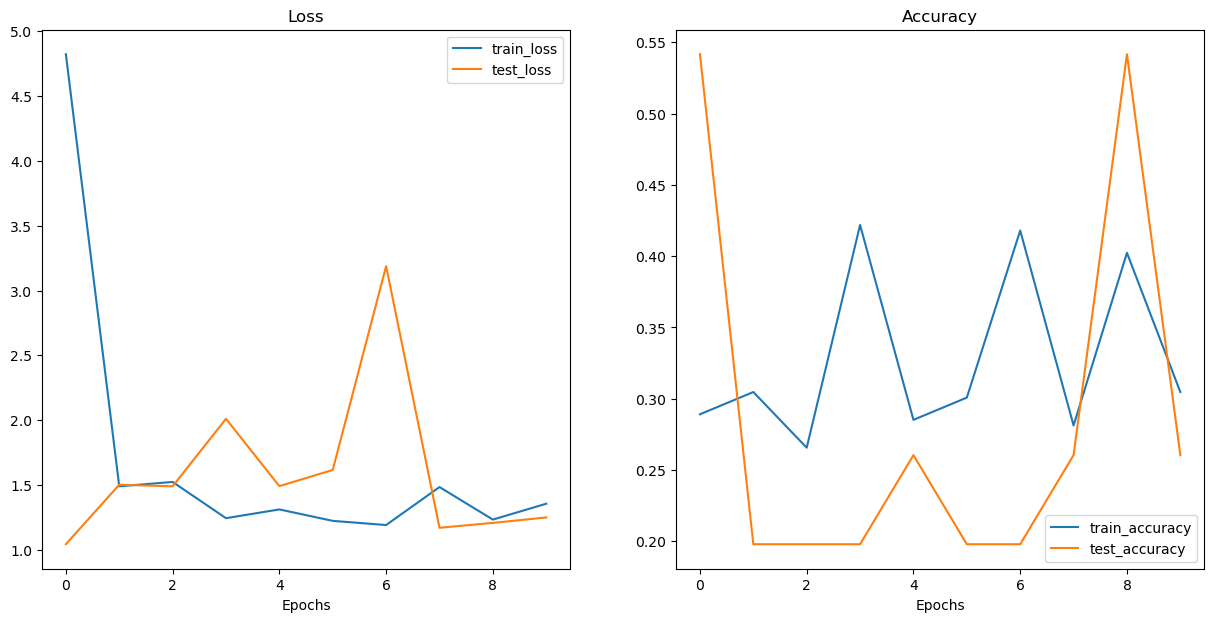

In [59]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

### 10. Using a pretrained ViT from 'torchvision.models'

Generally, in deep learning if you can use a pre-trained model from a large dataset on your own problem , it's often a good place to start.

In [60]:
import torchvision 
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"


In [61]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

#Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

pretrained_vit


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [62]:
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

In [63]:
from torchinfo import summary

summary(model=pretrained_vit,
        input_size = (1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names = ["input_size","output_size", "num_params","trainable"],
        col_width = 20,
        row_settings =["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 1000]            768                  False
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 197

In [64]:
#Update classifier head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features = 768,
                               out_features = len(class_names)).to(device)

#### 10.3 Prepraing data for pretrained model

When using a pretrained model, we want to make sure data is formatted in same way the model was trained on.

In [65]:
#Get automatic transform from pretrained vit weights
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [66]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [67]:
#Setup dataloaders
from going_modular.going_modular import data_setup
train_dataloader_pretrained , test_dataloader_pretrained , class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                      test_dir= test_dir,
                                                                                                      transform = vit_transforms,
                                                                                                      batch_size = 32) # could set a higher batch size

#### 10.4 Train feature extractor ViT model

In [68]:
from going_modular.going_modular import engine
set_seeds()
optimizer = torch.optim.Adam(pretrained_vit.parameters(),
                             lr= 1e-3,
                             betas = (0.9, 0.999),
                             weight_decay=0.1)
loss_fn = torch.nn.CrossEntropyLoss()
pretrained_vit_results = engine.train(model=pretrained_vit,
                      train_dataloader = train_dataloader_pretrained,
                      test_dataloader = test_dataloader_pretrained,
                      epochs = 10,
                      optimizer = optimizer,
                       loss_fn=loss_fn,
                       device = device
                      )


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7266 | test_loss: 0.5434 | test_acc: 0.8665
Epoch: 2 | train_loss: 0.3433 | train_acc: 0.9453 | test_loss: 0.3273 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2076 | train_acc: 0.9531 | test_loss: 0.2726 | test_acc: 0.9081
Epoch: 4 | train_loss: 0.1575 | train_acc: 0.9609 | test_loss: 0.2445 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.1270 | train_acc: 0.9727 | test_loss: 0.2304 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1264 | train_acc: 0.9766 | test_loss: 0.2158 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0985 | train_acc: 0.9766 | test_loss: 0.2407 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0858 | train_acc: 0.9844 | test_loss: 0.2325 | test_acc: 0.8778
Epoch: 9 | train_loss: 0.1180 | train_acc: 0.9883 | test_loss: 0.2094 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0744 | train_acc: 0.9922 | test_loss: 0.1821 | test_acc: 0.9176


#### 10.5 Plot loss curves of our ViT feature extractor model

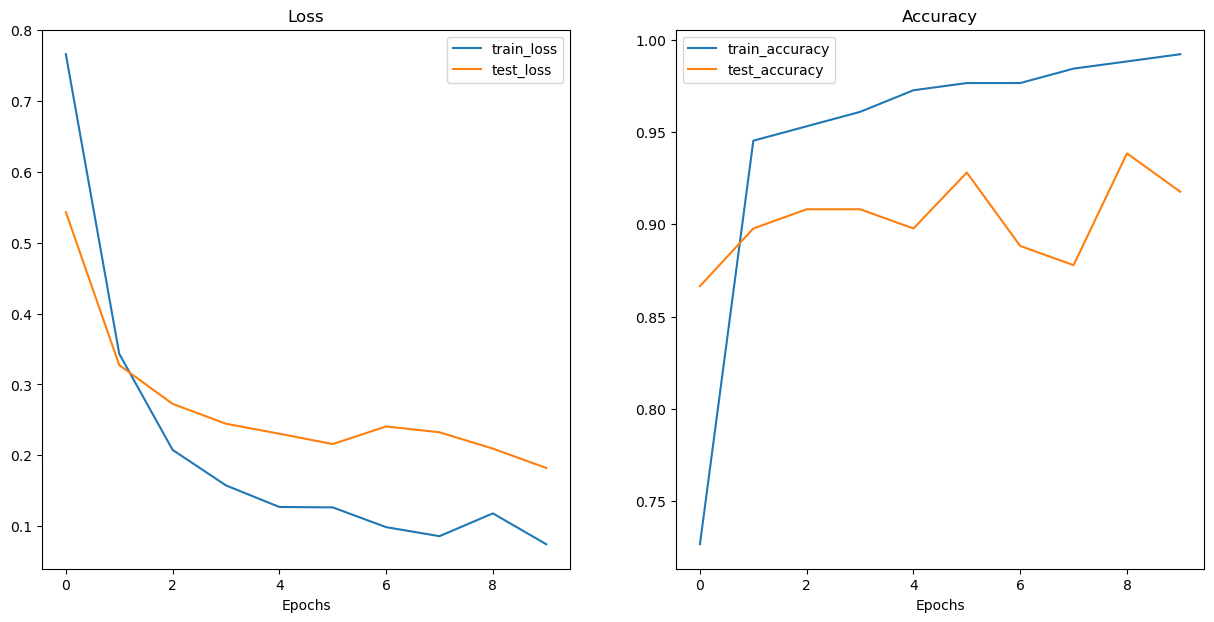

In [69]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

#### 10.6 Save our best performing ViT model


Now we've got a model that performs quite well, how about we save it to file and then check it's filesize.

We want to check the filesize because if we wanted to deploy a model to say on website/mobile application, we may have limitations on size of model we can deploy

In [70]:
#Save the model
from going_modular.going_modular import utils

utils.save_model(model = pretrained_vit,
                 target_dir = "models",
                 model_name = "08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [71]:
from pathlib import Path

#Get the model size in bytes , then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024)
print(f"Pretrained ViT feature extractor model size : {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size : 327 MB


Our pretrained ViT gets some of the best results we've seen so far on our FoodVision Mini problem, however, the model size is ~11x larger than our next best performing model.

Perhaps the larger model size might cause issues when we go to deploy it (e.g hard to deploy such a large file /might not take predictions as fast as a smaller model)

### 11. Predicting on a custom image

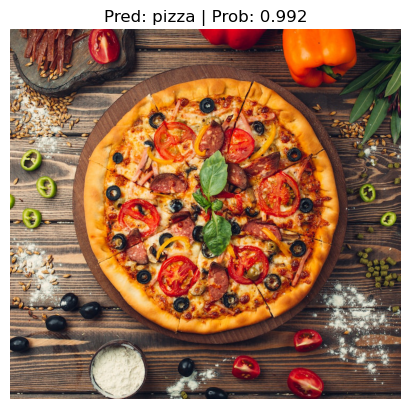

In [72]:
import requests
from pathlib import Path
from going_modular.going_modular.predictions import pred_and_plot_image
custom_image_path = Path("data/04_pizza.jpg")



if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
      request = requests.get("https://img.freepik.com/free-photo/pizza-pizza-filled-with-tomatoes-salami-olives_140725-1200.jpg?semt=ais_hybrid&w=740")
      print(f"Downloading {custom_image_path} ..")
      f.write(request.content)
else:
    print(f"{custom_image_path} already exists")

pred_and_plot_image(model=pretrained_vit,
                   image_path=custom_image_path,
                   class_names=class_names)

In [75]:
train_dir

PosixPath('data/pizza_steak_sushi/train')

In [80]:
from helper_functions import walk_through_dir

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.


In [79]:
image_path

PosixPath('data/pizza_steak_sushi')